In [ ]:
import os
import sys
import numpy as np
from glob import glob

!pip install pydicom
!pip install pylibjpeg pylibjpeg-libjpeg
import pydicom
!pip install antspyx
import ants
from google.colab import drive
drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/MyDrive/dicom_motion_preprocessing')

In [2]:
class DICOMImageProperties:
    """
    Class to load a directory of dicom slices. Designed as an example for 3D data
    """

    def __init__(self, dicom_files):
        self.dicom_files = sorted(dicom_files)  # Ensure files are sorted
        self.first_dicom_affine_matrix = None  # Initialize first DICOM affine matrix
        self.affine_matrix = None  # Initialize the affine matrix
        self.origin = None
        self.spacing = None
        self.dimensions = None

    def load_and_process_dicom_series(self):
        # Load the first and last DICOM file for basic properties
        first_dicom = pydicom.dcmread(self.dicom_files[0], force=True)
        last_dicom = pydicom.dcmread(self.dicom_files[-1], force=True) if len(self.dicom_files) > 1 else first_dicom

        # Image Orientation (Patient) (angular dealignment)
        iop = first_dicom.ImageOrientationPatient
        row_cosine = np.array(iop[0:3])
        col_cosine = np.array(iop[3:6])
        slice_cosine = np.cross(row_cosine, col_cosine)  # Cross product to get slice direction, i.e., z axis

        # Pixel Spacing (x, y)
        pixel_spacing = first_dicom.PixelSpacing

        # Calculate slice spacing more accurately (z)
        if len(self.dicom_files) > 1:
            if len(self.dicom_files) == 2:
                # Use first and last slice for slice spacing if there are exactly two slices
                slice_spacing = np.abs(last_dicom.ImagePositionPatient[2] - first_dicom.ImagePositionPatient[2])
            else:
                # For more than two slices, calculate average spacing based on all available slices
                slice_positions = [pydicom.dcmread(f, force=True).ImagePositionPatient[2] for f in self.dicom_files]
                slice_spacing = np.mean(np.diff(sorted(slice_positions)))
        if (len(self.dicom_files) == 0) or (slice_spacing == 0):
            # Fallback to slice thickness if there's only one slice
            slice_spacing = first_dicom.SliceThickness

        # Origin (translation)
        origin = first_dicom.ImagePositionPatient

        # Dimensions (image resolution grid)
        rows = first_dicom.Rows
        cols = first_dicom.Columns
        num_slices = len(self.dicom_files)

        # Affine Matrix
        self.affine_matrix = np.matrix([
            [row_cosine[0]*pixel_spacing[0], col_cosine[0]*pixel_spacing[1], slice_cosine[0]*slice_spacing, origin[0]],
            [row_cosine[1]*pixel_spacing[0], col_cosine[1]*pixel_spacing[1], slice_cosine[1]*slice_spacing, origin[1]],
            [row_cosine[2]*pixel_spacing[0], col_cosine[2]*pixel_spacing[1], slice_cosine[2]*slice_spacing, origin[2]],
            [0, 0, 0, 1]
        ])
        affine_matrix = np.matrix([
            [row_cosine[0]*pixel_spacing[0], col_cosine[0]*pixel_spacing[1], slice_cosine[0]*slice_spacing, origin[0]],
            [row_cosine[1]*pixel_spacing[0], col_cosine[1]*pixel_spacing[1], slice_cosine[1]*slice_spacing, origin[1]],
            [row_cosine[2]*pixel_spacing[0], col_cosine[2]*pixel_spacing[1], slice_cosine[2]*slice_spacing, origin[2]],
            [0, 0, 0, 1]
        ])
        self.first_dicom_affine_matrix = affine_matrix

        # Scaling Matrix
        scaling_matrix = np.matrix([
            [pixel_spacing[0], 0, 0, 0],
            [0, pixel_spacing[1], 0, 0],
            [0, 0, slice_spacing, 0],
            [0, 0, 0, 1]
        ])

        # Orientation (Rotation) Matrix
        orientation_matrix = np.matrix([
            [row_cosine[0], col_cosine[0], slice_cosine[0], 0],
            [row_cosine[1], col_cosine[1], slice_cosine[1], 0],
            [row_cosine[2], col_cosine[2], slice_cosine[2], 0],
            [0, 0, 0, 1]
        ])

        # Pretty print the affine matrix
        np.set_printoptions(precision=3, suppress=True)
        print("Scaling Matrix:")
        print(scaling_matrix)
        print("\n * Orientation (Rotation) Matrix:")
        print(orientation_matrix)
        print("\n = Affine Matrix (translation incl., not normarlized:")
        print(self.affine_matrix)

        # Setting origin, spacing, and dimensions
        self.origin = origin
        self.orientation = first_dicom.ImageOrientationPatient
        self.spacing = [pixel_spacing[0], pixel_spacing[1], slice_spacing]
        self.dimensions = [rows, cols, num_slices]
        self.q_form = self.affine_matrix.copy()
        self.spacing = [float(i) for i in self.spacing]
        self.dimensions = [int(i) for i in self.dimensions]
        # normalize affine_matrix according to itk convention
        self.affine_matrix[:3, :3] = self.affine_matrix[:3, :3] / self.spacing[:3]
        print("Affine Matrix (itk normalization)")
        print(self.affine_matrix)

        self._all_props = first_dicom

    def get_affine_matrix(self):
        if self.affine_matrix is None:
            self.load_and_process_dicom_series()
        return self.affine_matrix

    def get_image_size_attributes(self, info):

        datasize = [info.Rows, info.Columns]
        matrixsize = list(info.AcquisitionMatrix[i] for i in [0, 3])
        if (matrixsize[0] > 0) and (matrixsize[1] > 0):
            NumberOfTiles = [int(x)/int(y) for x,y in zip(datasize, matrixsize)]
        else:
            NumberOfTiles = [1,1]
            matrixsize = datasize

        return (datasize, matrixsize, NumberOfTiles)

    def get_orientation(self, affine):
        # Define the axis names based on direction
        axis_names = np.array(['R', 'L', 'A', 'P', 'S', 'I'])
        # Extract the direction cosines from the affine matrix
        direction_cosines = affine[:3, :3]
        # Initialize an empty string for the orientation
        orientation = ''
        # Loop through each column of the direction cosines matrix
        for i in range(3):
            # Extract the direction vector for the current axis
            direction_vector = direction_cosines[:, i]
            # Identify the major axis influenced by this direction vector (where the absolute value is max)
            major_axis_index = np.argmax(np.abs(direction_vector))
            # Determine the sign to decide between the two possible directions for the major axis
            sign = np.sign(direction_vector[major_axis_index])
            # Calculate the index in the axis_names array
            axis_name_index = major_axis_index * 2 + (0 if sign > 0 else 1)
            # Append the corresponding axis name to the orientation string
            orientation += axis_names[axis_name_index]

        return orientation

    def modify_affine_for_new_orientation(self, affine, new_orientation):
        current_orientation = self.get_orientation(affine)
        print(f"Original orientation: {current_orientation}")

        if (len(new_orientation) == 3) & (new_orientation.isalpha()):
          new_x = new_orientation[0].upper()
          new_y = new_orientation[1].upper()
          new_z = new_orientation[2].upper()
        else:
          raise ValueError('new orientation must be a 3 characer string (i.e. RAS)')

        # Transformation matrix to switch from current to destination orientation
        transform_matrix = np.zeros((3, 3))
        for i, char in enumerate(current_orientation):
            if char in 'LR':
                # Flip x-axis if needed to make it 'new_x'
                transform_matrix[i, 0] = 1 if char == new_x else -1
                flip_x = False if char == new_x else True
            elif char in 'PA':
                # Flip y-axis if needed to make it 'A'
                transform_matrix[i, 1] = 1 if char == new_y else -1
                flip_y = False if char == new_y else True
            elif char in 'IS':
                # z-axis 'S' is kept as is for LAS
                transform_matrix[i, 2] = 1 if char == new_z else -1
                flip_z = False if char == new_z else True

        # Compute the new rotation matrix
        new_rotation_matrix = self.affine_matrix[:3, :3].dot(transform_matrix)

        # Update the affine matrix with the new rotation
        new_affine = self.affine_matrix.copy()
        new_affine[:3, :3] = new_rotation_matrix

        # new_affine[0,3] -= self.spacing[0]/2
        # new_affine[1,3] -= self.spacing[1]/2

        if flip_x:
            new_affine[0, 3] += self.spacing[0] * (self.dimensions[0] - 1)
        else:
            new_affine[0, 3] += self.spacing[0]
        if flip_y:
            new_affine[1, 3] += self.spacing[1] * (self.dimensions[1] - 1)
        else:
            new_affine[1, 3] += self.spacing[1]
        if flip_z:
            new_affine[2, 3] += self.spacing[2] * (self.dimensions[2] - 1)

        current_orientation = self.get_orientation(new_affine)
        print(f"New orientation: {current_orientation}")
        return new_affine, (flip_x, flip_y, flip_z)

load a 3D dataset and print out the affine.

In [3]:
dcmpath = '/content/drive/MyDrive/dicom_motion_preprocessing/test_series/brain_mapping_meso'
#dcmpath = '/content/drive/MyDrive/dicom_motion_preprocessing/test_series/brain_mapping_fmri_sms_verb_generation'
#dcmpath = '/content/drive/MyDrive/images/DICOM_series/test_series'
pattern = os.path.join(dcmpath, '*dcm')
dicom_files = sorted(glob(pattern), key=os.path.getctime)
try:
  # Function to safely get InstanceNumber
  def get_instance_number(dicom_path):
      try:
          return int(pydicom.dcmread(dicom_path, force=True).InstanceNumber)
      except AttributeError:
          return float('inf')  # Return a value that sorts last if InstanceNumber is missing

  # Sort files by InstanceNumber
  dicom_files = sorted(dicom_files, key=get_instance_number)
except:
  pass

dcm = DICOMImageProperties(dicom_files)

In [4]:
dcm.load_and_process_dicom_series()
#print(dcm._all_props)

Scaling Matrix:
[[1.692 0.    0.    0.   ]
 [0.    1.692 0.    0.   ]
 [0.    0.    3.    0.   ]
 [0.    0.    0.    1.   ]]

 * Orientation (Rotation) Matrix:
[[ 1.     0.001 -0.     0.   ]
 [-0.001  1.     0.     0.   ]
 [ 0.     0.     1.     0.   ]
 [ 0.     0.     0.     1.   ]]

 = Affine Matrix (translation incl., not normarlized:
[[   1.692    0.002   -0.    -879.269]
 [  -0.002    1.692    0.    -886.596]
 [   0.       0.       3.     -61.585]
 [   0.       0.       0.       1.   ]]
Affine Matrix (itk normalization)
[[   1.       0.001   -0.    -879.269]
 [  -0.001    1.       0.    -886.596]
 [   0.       0.       1.     -61.585]
 [   0.       0.       0.       1.   ]]


In [5]:
affine_orig = dcm.get_affine_matrix()

print("Basic affine matrix: \n", affine_orig)
print("Original Orientation: ", dcm.get_orientation(affine_orig))

Basic affine matrix: 
 [[   1.       0.001   -0.    -879.269]
 [  -0.001    1.       0.    -886.596]
 [   0.       0.       1.     -61.585]
 [   0.       0.       0.       1.   ]]
Original Orientation:  RAS


In [6]:
affine_rps, flipping = dcm.modify_affine_for_new_orientation(affine_orig, 'RPS')
print(affine_rps)
print("flipped along: ",flipping)

Original orientation: RAS
New orientation: RPS
[[   1.      -0.001    0.    -877.576]
 [  -0.001   -1.       0.     871.712]
 [   0.       0.       1.     -61.585]
 [   0.       0.       0.       1.   ]]
flipped along:  (False, True, False)


In [7]:
affine_ras, flipping = dcm.modify_affine_for_new_orientation(affine_orig, 'RAS')
print(affine_ras)
print("flipped along: ",flipping)

Original orientation: RAS
New orientation: RAS
[[   1.       0.001    0.    -877.576]
 [  -0.001    1.       0.    -884.904]
 [   0.       0.       1.     -61.585]
 [   0.       0.       0.       1.   ]]
flipped along:  (False, False, False)


Validation: load the nifti version converted by dcm2niix

ANTS Affine Matrix:
 [[ 1.    -0.001  0.     0.   ]
 [-0.001 -1.     0.     0.   ]
 [ 0.     0.     1.     0.   ]
 [ 0.     0.     0.     1.   ]]
ANTS Origin: (-107.88932800292969, 100.63549041748047, -61.5854606628418, 0.0)
ANTS Orientation: RPS

Shape of the NIfTI file: (130, 130, 64, 22)


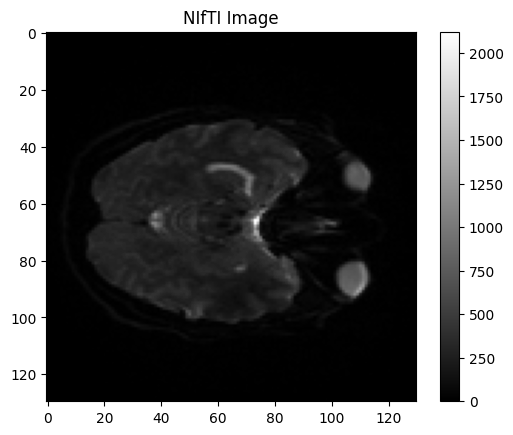

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 57
dim             : [  4 130 130  64  22   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.     1.692  1.692  3.     3.8    0.     0.     0.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'TE=96;Time=135244.047'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0006981205
quatern_c       : 0.99999976
quatern_d       : 0.0
qoffset_x       : 107.88933
qoffset_y       : -100.

In [8]:
#niipath = '/content/drive/MyDrive/dicom_motion_preprocessing/test_series/ax_t1_dcm2niix_34.nii'
niipath = '/content/drive/MyDrive/dicom_motion_preprocessing/test_series/brain_mapping_meso_dcm2niix_35.nii'
#niipath = '/content/drive/MyDrive/dicom_motion_preprocessing/test_series/brain_mapping_fmri_sms_verb_generation_dcm2niix_10.nii'
#niipath = '/content/drive/MyDrive/images/DICOM_series/nii/DIFF_meso_2_TE96_9.nii'
img = ants.image_read(niipath)
print("ANTS Affine Matrix:\n", img.direction)
print("ANTS Origin:", img.origin)
print("ANTS Orientation:", dcm.get_orientation(img.direction))
print()
import nibabel as nib
nifti_img = nib.load(niipath)
nifti_data = nifti_img.get_fdata()
shape = nifti_data.shape
print("Shape of the NIfTI file:", shape)
import matplotlib.pyplot as plt
plt.imshow(nifti_data[:, :, 20, 1], cmap='gray')  # Adjust the slice index as needed
plt.colorbar()
plt.title('NIfTI Image')
plt.show()
header = nifti_img.header
print(header)
# Leer las transformaciones qform y sform
qform_matrix = nifti_img.get_qform()
sform_matrix = nifti_img.get_sform()
print(qform_matrix)
print(sform_matrix)

In [9]:
image=img
# Get the affine matrix components
rotation = image.direction
spacing = image.spacing
origin = image.origin
direction_matrix = image.direction
full_affine_matrix = direction_matrix.copy()
full_affine_matrix[:3, 3] = origin[:3]
print(f'ANTs complete Affine Matrix: translation added and "{dcm.get_orientation(img.direction)}" orientation:')
print(full_affine_matrix)

ANTs complete Affine Matrix: translation added and "RPS" orientation:
[[   1.      -0.001    0.    -107.889]
 [  -0.001   -1.       0.     100.635]
 [   0.       0.       1.     -61.585]
 [   0.       0.       0.       1.   ]]


In [10]:
affine_rps, flipping = dcm.modify_affine_for_new_orientation(affine_orig, 'RPS')
comparison_matrix = np.isclose(full_affine_matrix, affine_rps, atol=1e-3)
print("Element-wise comparison matrix (True means a match up to three decimals):")
print(comparison_matrix)
full_affine_matrix, affine_orig

Original orientation: RAS
New orientation: RPS
Element-wise comparison matrix (True means a match up to three decimals):
[[ True  True  True False]
 [ True  True  True False]
 [ True  True  True  True]
 [ True  True  True  True]]


(array([[   1.   ,   -0.001,    0.   , -107.889],
        [  -0.001,   -1.   ,    0.   ,  100.635],
        [   0.   ,    0.   ,    1.   ,  -61.585],
        [   0.   ,    0.   ,    0.   ,    1.   ]]),
 matrix([[   1.   ,    0.001,   -0.   , -879.269],
         [  -0.001,    1.   ,    0.   , -886.596],
         [   0.   ,    0.   ,    1.   ,  -61.585],
         [   0.   ,    0.   ,    0.   ,    1.   ]]))

In [11]:
import os
import numpy as np
import pydicom

def init_mosaic_dicom(files, datasize, matrixsize, NumberOfTiles, nmos, in_folder):
    """
    If the data is in mosaic format:

    Create an empty array of matrix size, number of mosaic tiles.
    The number of files output volume is 4D.
    """
    imagevol = np.zeros((matrixsize[0], matrixsize[1], int(nmos), len(files)))
    series_grad = np.zeros((len(files), 4))

    for i, file in enumerate(files):
        info = pydicom.dcmread(os.path.join(in_folder, file), force=True)
        instance = int(info.InstanceNumber) - 1


        data = info.pixel_array
        img = np.reshape(data, (datasize[0], datasize[1]), order='F')
        c = 0
        for j in range(1, int(NumberOfTiles[0])+1):
            for k in range(1, int(NumberOfTiles[1])+1):
                if c > nmos-1:
                    continue
                imagevol[:,:,c,instance] = img[(j-1)*matrixsize[0]:(j)*matrixsize[0], (k-1)*matrixsize[1]:(k)*matrixsize[1]]
                c += 1

    return imagevol


In [12]:
from drive.MyDrive.code import mputils

In [13]:
def get_slice_index(info):
    try:
        csa = info[0x0029,0x1010].value
        csaobj = mputils.Unpacker(csa, endian='<')
        csadict = csaobj.csaread(csa)
        nmos = csadict['tags']['NumberOfImagesInMosaic']['items'][0]
        return nmos
    except:
        print('excpt')
        datasize = [info.Rows, info.Columns]
        matrixsize = list(info.AcquisitionMatrix[i] for i in [0, 3])

        if (matrixsize[0] > 0) and (matrixsize[1] > 0):
            NumberOfTiles = [int(x)/int(y) for x,y in zip(datasize, matrixsize)]
        else:
            NumberOfTiles = [1,1]
            matrixsize = datasize
        return int(np.prod(NumberOfTiles))

(datasize, matrixsize, NumberOfTiles) = dcm.get_image_size_attributes(dcm._all_props)
nmos = get_slice_index(dcm._all_props)
image = init_mosaic_dicom(dicom_files, datasize, matrixsize, NumberOfTiles, nmos, dcmpath)
print(datasize, matrixsize, NumberOfTiles, nmos, dcmpath)

excpt
[1040, 1040] [130, 130] [8.0, 8.0] 64 /content/drive/MyDrive/dicom_motion_preprocessing/test_series/brain_mapping_meso


In [14]:
import numpy as np

def update_affine_matrix_origin(affine_matrix, new_orig):
    """
    Update the last column of the affine matrix with new origin values.
    Handles both 3-element and 4-element tuples/lists for new_origin.

    Parameters:
    - affine_matrix: numpy.ndarray, the original affine matrix.
    - new_origin: tuple or list, the new origin coordinates as strings or numbers.
                  Can be a 3-element tuple/list (x, y, z) or a 4-element tuple/list (x, y, z, w).

    Returns:
    - Updated affine matrix as a numpy.ndarray.
    """
    # Convert all new_origin values to floats
    new_origin_floats = [float(x) for x in new_orig]

    # If new_origin is a 3-element tuple/list, add the homogeneous coordinate
    if len(new_orig) == 3:
        new_origin_floats.append(1.0)  # Add the homogeneous coordinate for 3D points

    # Update the last column of the affine matrix with the new origin
    affine_matrix[:, -1:] = np.array(new_origin_floats).reshape(4, 1)

    return affine_matrix


In [15]:
import numpy as np

def nii_flipY(image, header):
    # Step 1: Create the Y-flip matrix
    mFlipY = np.array([[1.0, 0.0, 0.0],
                       [0.0, -1.0, 0.0],
                       [0.0, 0.0, 1.0]])

    # Extract the current orientation matrix 's' from the NIfTI header
    s = header[:3, :3]

    # Step 2: Multiply the current orientation matrix by the Y-flip matrix
    s_flipped = np.dot(s, mFlipY)

    # Step 3: Update the transformation matrix with the new orientation
    # Flatten the translation_vector to ensure it is 1-dimensional
    translation_vector = header[:3, 3].flatten()  # Flatten to ensure shape (3,)
    Q44_updated = np.eye(4)  # Initialize as identity matrix for safety
    Q44_updated[:3, :3] = s_flipped
    Q44_updated[:3, 3] = translation_vector  # Assign the flattened vector

    # Step 4: Update the NIfTI header (conceptual, depends on your implementation)
    header_updated = Q44_updated  # This represents updating the header's affine matrix

    # Step 5: Flip the image data along the Y-axis
    image_flipped = np.flip(image, axis=1)  # Flips along the second dimension

    # Return the flipped image and the updated header
    return image_flipped, header_updated

# Usage (assuming 'nifti_data' is your image data and 'new_m' is your affine matrix)
# nifti_data_flipped, affine_updated = nii_flipY(nifti_data, new_m)

In [17]:
def adjust_origin(ipp, q_matrix, slice_index, slices_per_row, mosaic_dims_in_pixels):

    # Calculate row and column of the slice in the mosaic
    row = slice_index // slices_per_row
    col = slice_index % slices_per_row

    # Calculate the offset in pixels
    offset_x_pixels = col * (mosaic_dims_in_pixels[1] / 2 / slices_per_row)
    offset_y_pixels = row * (mosaic_dims_in_pixels[0] / 2 / slices_per_row)

    # Convert the offset to physical units (millimeters)
    offset_x_mm = offset_x_pixels*q_matrix[0,0] + q_matrix[0,1]*offset_y_pixels
    offset_y_mm = offset_x_pixels*q_matrix[1,0] + q_matrix[1,1]*offset_y_pixels

    # Adjust the IPP to refer to the correct voxel in the 3D volume
    adjusted_ipp = [
        ipp[0] + offset_x_mm,
        ipp[1] + offset_y_mm,
        ipp[2]  # Assuming slice thickness or spacing is accounted for elsewhere
    ]

    return adjusted_ipp

#print(datasize, matrixsize, NumberOfTiles, nmos)
#print(img.shape)
new_o = adjust_origin(dcm.origin, dcm.first_dicom_affine_matrix, nmos-1, NumberOfTiles[0], datasize)
original_matrix = update_affine_matrix_origin(dcm.first_dicom_affine_matrix, dcm.origin)
print("Original matrix ("+dcm.get_orientation(original_matrix)+"):\n", original_matrix)

new_m = update_affine_matrix_origin(dcm.first_dicom_affine_matrix, new_o)
ants_matrix = update_affine_matrix_origin(img.direction, img.origin)

#flip Y axis
# translation values
v = np.array([0, nifti_data.shape[1] - 1, 0, 1])
m = new_m
vO = np.dot(m, v)
# matrix core
image_flipped, header_updated = nii_flipY(nifti_data,dcm.affine_matrix)
#mix together:
header_updated[:, -1] = vO.flatten()  # Ensures vO is 1D and assigns it

print("New matrix ("+dcm.get_orientation(header_updated)+"):\n", header_updated)
print("ANTs matrix ("+dcm.get_orientation(ants_matrix)+"):\n", ants_matrix)

Original matrix (RAS):
 [[   1.692    0.002   -0.    -879.269]
 [  -0.002    1.692    0.    -886.596]
 [   0.       0.       3.     -61.585]
 [   0.       0.       0.       1.   ]]
New matrix (RPS):
 [[   1.      -0.001    0.    -107.889]
 [  -0.001   -1.       0.     100.635]
 [   0.       0.       1.     -61.585]
 [   0.       0.       0.       1.   ]]
ANTs matrix (RPS):
 [[   1.      -0.001    0.    -107.889]
 [  -0.001   -1.       0.     100.635]
 [   0.       0.       1.     -61.585]
 [   0.       0.       0.       0.   ]]


---

# Here is where we keep track of image flipping!




In [ ]:
def dicom_series3d_to_volume(directory):
    dicom_files = [pydicom.dcmread(os.path.join(directory, f)) for f in os.listdir(directory) if f.endswith('.dcm')]
    dicom_files.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    return dicom_files

In [ ]:
def dicom_series4d_to_volume(directory):
    # Read all DICOM files in the directory
    dicom_files = [pydicom.dcmread(os.path.join(directory, f)) for f in os.listdir(directory) if f.endswith('.dcm')]

    # Sort DICOM files based on slice position and acquisition time
    dicom_files.sort(key=lambda x: (float(x.ImagePositionPatient[2]), x.AcquisitionTime))

    return dicom_files

In [ ]:
from dicom_io import Dicom
dicom_in_folder = "/content/drive/MyDrive/images/DICOM_series/test_series/"
DCM = Dicom(dicom_in_folder)
im, dcmdict = DCM.initialize()

...reading input data


In [ ]:
import matplotlib.pyplot as plt  # Import the matplotlib module

Displaying the 2D image


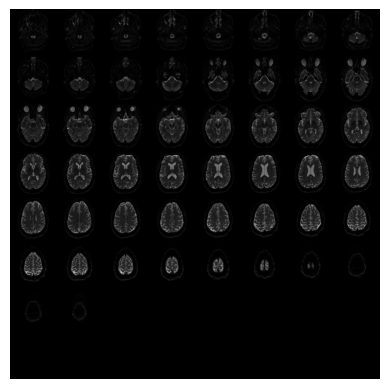

In [ ]:
image_data = dcm._all_props.pixel_array
slice_data = image_data
print("Displaying the 2D image")
plt.imshow(slice_data, cmap='gray')
plt.axis('off')  # Hide the axis for clarity
plt.show()

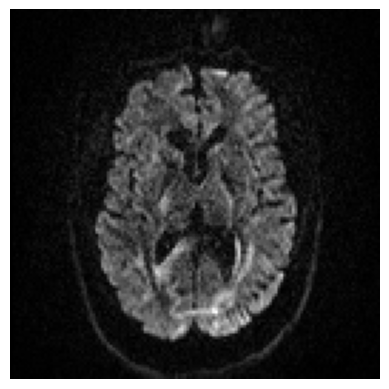

In [ ]:
plt.imshow(im[:,:,25,30], cmap='gray')
plt.axis('off')  # Hide the axis for clarity
plt.show()

In [ ]:
filestack = dicom_series4d_to_volume(dcmpath)
volume = np.stack([s.pixel_array for s in filestack]).astype(np.float32).transpose(2,1,0)
from dicom_io import Dicom
dicom_in_folder = "/content/drive/MyDrive/images/DICOM_series/test_series/"
DCM = Dicom(dicom_in_folder)
#volume, dcmdict = DCM.initialize()

flip_index = np.where(flipping)[0]
if flip_index.any():
  volume = np.flip(volume, flip_index)

ants_image = ants.from_numpy(volume)
ants_image.set_spacing(dcm.spacing)
ants_image.set_origin(affine_ras[:3,3].flatten().tolist()[0])
ants_image.set_direction(np.array(affine_ras[:3,:3]))
ants_image.to_file('/content/drive/MyDrive/dicom_motion_preprocessing/test_series/ax_t1_micsi_34.nii')


In [ ]:
pip install pydicom matplotlib

Displaying the 2D image


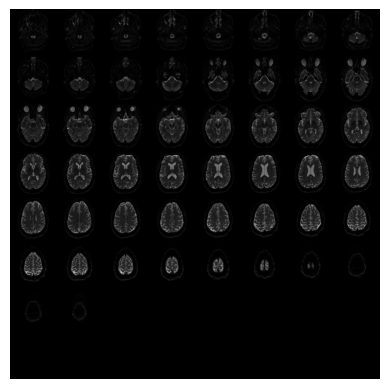

In [ ]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt

# Path to your DICOM file
dicom_file_path = '/content/drive/MyDrive/images/DICOM_series/test_series/1.3.12.2.1107.5.2.43.67041.2018091610564975891187188.0.0.0#IM_0001.dcm'
#dicom_file_path = '/content/drive/MyDrive/dicom_motion_preprocessing/test_series/ax_t1/MR.1.2.276.0.45.1.7.3.207360514638673.23101116182700557.50676.17.dcm'

ds = pydicom.dcmread(dicom_file_path)
image_data = ds.pixel_array
slice_data = image_data
print("Displaying the 2D image")
plt.imshow(slice_data, cmap='gray')
plt.axis('off')  # Hide the axis for clarity
plt.show()

In [ ]:
from dicom_io import Dicom
dicom_in_folder = "/content/drive/MyDrive/images/DICOM_series/test_series/"
DCM = Dicom(dicom_in_folder)
im, dcmdict = DCM.initialize()

...reading input data
